In [1]:
import json
import os
import re
from types import SimpleNamespace

import torch
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from utils.data_loader import load_celeba
from model.feature_enc import ConvDecoder
from model.vi_encoder import VIEncoder

In [2]:
pearson = False
kl = "kl1e-3"
samp = 10
z_list = [64, 512, 1024, 2048]
p_sparsity = 10

file_list = [
    f"results_celeba/gaussian_{kl}",
    f"results_celeba/{p_sparsity}/concreteslab_{kl}",
    f"results_celeba/{p_sparsity}/gaussian_thresh_{kl}",
    f"results_celeba/{p_sparsity}/gaussian_learnthresh_{kl}",
    f"results_celeba/{p_sparsity}/laplacian_thresh_{kl}",
    f"results_celeba/{p_sparsity}/laplacian_learnthresh_{kl}",
]

file_labels = [
    "Gaussian",
    "Spike-and-Slab",
    "Thresh Gaussian",
    "Thresh Gaussian+Gamma",
    "Thresh Laplacian",
    "Thresh Laplacian+Gamma",
]

In [3]:
default_device = torch.device('cuda:0')
with open(file_list[0] + "_z" + str(z_list[0]) + '_v1/config.json') as json_data:
    config_data = json.load(json_data)
#logging.basicConfig(filename=f"figures/vsc_grad_stats/vscgrad_{file_suffix}.txt", 
#                    filemode='w', level=logging.DEBUG)
train_args = SimpleNamespace(**config_data['train'])
train_args.batch_size = 100
train_args.val_samples = 15000
_, small_testloader = load_celeba("./data/", train_args)

In [4]:
from pyitlib import discrete_random_variable as drv
import torch.nn.functional as F

inferred_codes = {}
multi_info = {}
image_est = {}
mse_dict = {}

for file_idx, base_run in enumerate(file_list):
    print(f"{file_labels[file_idx]}")
    multi_info[file_labels[file_idx]] = {}
    inferred_codes[file_labels[file_idx]] = {}
    image_est[file_labels[file_idx]] = {}
    mse_dict[file_labels[file_idx]] = {}

    for z in z_list:
        inferred_codes[file_labels[file_idx]][str(z)] = np.zeros((3, len(small_testloader.dataset), z))
        mse_dict[file_labels[file_idx]][str(z)] = np.zeros(3)
        image_est[file_labels[file_idx]][str(z)] = np.zeros((3, len(small_testloader.dataset), 3, 64, 64))
        multi_info[file_labels[file_idx]][str(z)] = np.zeros(3)

        for v in range(3):
            train_run = base_run + f"_z{z}_v{v+1}/"
            with open(train_run + 'config.json') as json_data:
                config_data = json.load(json_data)
            train_args = SimpleNamespace(**config_data['train'])
            solver_args = SimpleNamespace(**config_data['solver'])

            train_args.batch_size = 100
            solver_args.sample_method = "max"
            solver_args.num_samples = 20

            epoch_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(train_run) if re.search(r'epoch([0-9].*).pt', f)]
            epoch_list = np.sort(epoch_list)
            epoch_list = [epoch_list[-1]]

            for epoch in epoch_list:
                np.random.seed(train_args.seed)
                torch.manual_seed(train_args.seed)

                model_state = torch.load(train_run + f"modelstate_epoch{epoch}.pt", map_location=default_device)
                decoder = ConvDecoder(train_args.dict_size, 3).to(default_device)
                decoder.load_state_dict(model_state['decoder'])

                if solver_args.solver == "VI":
                    encoder = VIEncoder(16, train_args.dict_size, solver_args).to(default_device)  
                    encoder.load_state_dict(model_state['encoder'])
                    encoder.ramp_hyperparams()
                    encoder.eval()
                decoder.eval()
                
                with torch.no_grad():
                    for idx, (x, y) in enumerate(small_testloader):
                        x, y = x.to(default_device), y.to(default_device)
                        iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(x, decoder)

                        sample_idx = torch.distributions.categorical.Categorical(weight).sample().detach()
                        b_select = b_cu[torch.arange(len(b_cu)), sample_idx].detach()
                        x_hat = decoder(b_select).detach()

                        inferred_codes[file_labels[file_idx]][str(z)][v, idx*train_args.batch_size:(idx+1)*train_args.batch_size] = b_select.cpu().numpy()
                        image_est[file_labels[file_idx]][str(z)][v, idx*train_args.batch_size:(idx+1)*train_args.batch_size] = x_hat.cpu().numpy()
                        mse_dict[file_labels[file_idx]][str(z)][v] += F.mse_loss(x_hat, x).item()

            bins = np.linspace(-2, 2, 30)
            bins = np.sort(np.append(bins, [-1e-50, 1e-50]))
            alphabet = np.tile(np.arange(len(bins)+1), (inferred_codes[file_labels[file_idx]][str(z)][v].shape[1], 1))   
            discrete_codes = np.digitize(inferred_codes[file_labels[file_idx]][str(z)][v].T, bins)
            multi_info[file_labels[file_idx]][str(z)][v] = drv.information_multi(discrete_codes, Alphabet_X=alphabet)
            print(f"z {z}, epoch {epoch}, MI: {multi_info[file_labels[file_idx]][str(z)][v]:.3E}, MSE: {mse_dict[file_labels[file_idx]][str(z)][v]:.3E}") 
        print()         

Gaussian
z 64, epoch 300, MI: 2.071E+02, MSE: 2.634E+00
z 64, epoch 300, MI: 2.073E+02, MSE: 2.632E+00
z 64, epoch 300, MI: 2.072E+02, MSE: 2.635E+00

z 512, epoch 300, MI: 1.743E+03, MSE: 2.676E+00
z 512, epoch 300, MI: 1.743E+03, MSE: 2.700E+00
z 512, epoch 300, MI: 1.743E+03, MSE: 2.673E+00

z 1024, epoch 300, MI: 3.497E+03, MSE: 2.764E+00
z 1024, epoch 300, MI: 3.499E+03, MSE: 2.822E+00
z 1024, epoch 300, MI: 3.498E+03, MSE: 2.784E+00

z 2048, epoch 300, MI: 7.009E+03, MSE: 3.034E+00
z 2048, epoch 300, MI: 7.009E+03, MSE: 3.098E+00
z 2048, epoch 300, MI: 7.010E+03, MSE: 3.098E+00

Spike-and-Slab
z 64, epoch 300, MI: 3.796E+01, MSE: 3.543E+00
z 64, epoch 300, MI: 3.632E+01, MSE: 3.538E+00
z 64, epoch 300, MI: 3.535E+01, MSE: 3.548E+00

z 512, epoch 300, MI: 3.821E+02, MSE: 3.281E+00
z 512, epoch 300, MI: 3.818E+02, MSE: 3.286E+00
z 512, epoch 300, MI: 3.820E+02, MSE: 3.289E+00

z 1024, epoch 300, MI: 7.658E+02, MSE: 3.267E+00
z 1024, epoch 300, MI: 7.662E+02, MSE: 3.254E+00
z 1024, 

In [5]:
import torchvision.transforms.functional as F
default_device = torch.device('cuda:1')

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(default_device)
model.fc = torch.nn.Identity()
model.eval()

gt_feat = []
with torch.no_grad():
    for idx, (x, y) in enumerate(small_testloader):
        x = F.resize(x, (299,299))
        x = x.to(default_device)
        feat = model(x).detach().cpu().numpy()
        gt_feat.append(feat)
gt_feat = np.stack(gt_feat).reshape(-1, 2048)

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
import scipy as sp

fid = {}
for file_idx, base_run in enumerate(file_list):
    print(f"{file_labels[file_idx]}")
    fid[file_labels[file_idx]] = {}
    for z in z_list:
        fid[file_labels[file_idx]][str(z)] = np.zeros(3)
        for v in range(3):
            test_feat = []
            for j in range(len(small_testloader.dataset) // 50):
                x = image_est[file_labels[file_idx]][str(z)][v, j*50:(j+1)*50]
                x = F.resize(torch.tensor(x).float(), (299,299))
                x = x.to(default_device)
                feat = model(x).detach().cpu().numpy()
                test_feat.append(feat)
            test_feat = np.stack(test_feat).reshape(-1, 2048)

            mu1, mu2 = np.mean(gt_feat[:5000], axis=0), np.mean(test_feat[:5000], axis=0)
            sigma1, sigma2 = np.cov(gt_feat[:5000]), np.cov(test_feat[:5000])        
            eps = 1e-6

            # Code below taken from: https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py
            mu_diff = mu1 - mu2
            # Product might be almost singular
            covmean, _ = sp.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
            if not np.isfinite(covmean).all():
                msg = ('fid calculation produces singular product; '
                    'adding %s to diagonal of cov estimates') % eps
                print(msg)
                offset = np.eye(sigma1.shape[0]) * eps
                covmean = sp.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
            # Numerical error might give slight imaginary component
            if np.iscomplexobj(covmean):
                if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                    m = np.max(np.abs(covmean.imag))
                    raise ValueError('Imaginary component {}'.format(m))
                covmean = covmean.real

            tr_covmean = np.trace(covmean)
            fid[file_labels[file_idx]][str(z)][v] = (mu_diff.dot(mu_diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

            print(f"z {z}, epoch {epoch}, FID: {fid[file_labels[file_idx]][str(z)][v]:.3E}") 
        print()         


Gaussian
z 64, epoch 300, FID: 4.279E+02
z 64, epoch 300, FID: 4.263E+02
z 64, epoch 300, FID: 4.282E+02

z 512, epoch 300, FID: 4.305E+02
z 512, epoch 300, FID: 4.322E+02
z 512, epoch 300, FID: 4.301E+02

z 1024, epoch 300, FID: 4.334E+02
z 1024, epoch 300, FID: 4.358E+02
z 1024, epoch 300, FID: 4.384E+02

z 2048, epoch 300, FID: 4.464E+02
z 2048, epoch 300, FID: 4.484E+02
z 2048, epoch 300, FID: 4.493E+02

Spike-and-Slab
z 64, epoch 300, FID: 4.565E+02
z 64, epoch 300, FID: 4.559E+02
z 64, epoch 300, FID: 4.573E+02

z 512, epoch 300, FID: 4.539E+02
z 512, epoch 300, FID: 4.517E+02
z 512, epoch 300, FID: 4.513E+02

z 1024, epoch 300, FID: 4.533E+02
z 1024, epoch 300, FID: 4.498E+02
z 1024, epoch 300, FID: 4.501E+02

z 2048, epoch 300, FID: 4.510E+02
z 2048, epoch 300, FID: 4.503E+02
z 2048, epoch 300, FID: 4.514E+02

Thresh Gaussian
z 64, epoch 300, FID: 4.614E+02
z 64, epoch 300, FID: 4.610E+02
z 64, epoch 300, FID: 4.610E+02

z 512, epoch 300, FID: 4.229E+02
z 512, epoch 300, FID: 4

In [7]:
import torch.nn.functional as F

sparse_mse = {}
sparsity_degree = [5, 10, 20, 50]
train_args.batch_size = 80

for file_idx, base_run in enumerate(file_list[1:]):
    print(file_labels[file_idx+1])
    sparse_mse[file_labels[file_idx+1]] = {}
    for sparsity in sparsity_degree:
        sparse_mse[file_labels[file_idx+1]][str(sparsity)] = np.zeros(3)

        for v in range(3):
            train_run = (base_run + f"_z512_v{v+1}/").replace("/10/", f"/{sparsity}/")
            with open(train_run + 'config.json') as json_data:
                config_data = json.load(json_data)
            train_args = SimpleNamespace(**config_data['train'])
            solver_args = SimpleNamespace(**config_data['solver'])

            train_args.batch_size = 80
            solver_args.sample_method = "max"
            solver_args.num_samples = 20

            epoch_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(train_run) if re.search(r'epoch([0-9].*).pt', f)]
            epoch_list = np.sort(epoch_list)
            epoch_list = [epoch_list[-1]]

            for epoch in epoch_list:
                np.random.seed(train_args.seed)
                torch.manual_seed(train_args.seed)

                model_state = torch.load(train_run + f"modelstate_epoch{epoch}.pt", map_location=default_device)
                decoder = ConvDecoder(train_args.dict_size, 3, im_size=64).to(default_device)
                decoder.load_state_dict(model_state['decoder'])

                if solver_args.solver == "VI":
                    encoder = VIEncoder(16, train_args.dict_size, solver_args).to(default_device)
                    encoder.load_state_dict(model_state['encoder'])
                    encoder.ramp_hyperparams()
                    encoder.eval()
                decoder.eval()
                
                with torch.no_grad():
                    for idx, (x, y) in enumerate(small_testloader):
                        x, y = x.to(default_device), y.to(default_device)
                        iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(x, decoder)

                        sample_idx = torch.distributions.categorical.Categorical(weight).sample().detach()
                        b_select = b_cu[torch.arange(len(b_cu)), sample_idx].detach()
                        x_hat = decoder(b_select)
                        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
                        sparse_mse[file_labels[file_idx+1]][str(sparsity)][v] += recon_loss.item()

            print(f"sparsity {sparsity} v{v+1} epoch {epoch}, mse loss: {sparse_mse[file_labels[file_idx+1]][str(sparsity)][v]:.3E}") 
        print()         

Spike-and-Slab
sparsity 5 v1 epoch 300, mse loss: 3.339E+00
sparsity 5 v2 epoch 300, mse loss: 3.329E+00
sparsity 5 v3 epoch 300, mse loss: 3.334E+00

sparsity 10 v1 epoch 300, mse loss: 3.281E+00
sparsity 10 v2 epoch 300, mse loss: 3.286E+00
sparsity 10 v3 epoch 300, mse loss: 3.289E+00

sparsity 20 v1 epoch 300, mse loss: 3.282E+00
sparsity 20 v2 epoch 300, mse loss: 3.270E+00
sparsity 20 v3 epoch 300, mse loss: 3.276E+00

sparsity 50 v1 epoch 300, mse loss: 3.369E+00
sparsity 50 v2 epoch 300, mse loss: 3.364E+00
sparsity 50 v3 epoch 300, mse loss: 3.370E+00

Thresh Gaussian
sparsity 5 v1 epoch 300, mse loss: 2.643E+00
sparsity 5 v2 epoch 300, mse loss: 2.637E+00
sparsity 5 v3 epoch 300, mse loss: 2.637E+00

sparsity 10 v1 epoch 300, mse loss: 2.430E+00
sparsity 10 v2 epoch 300, mse loss: 2.429E+00
sparsity 10 v3 epoch 300, mse loss: 2.427E+00

sparsity 20 v1 epoch 300, mse loss: 2.360E+00
sparsity 20 v2 epoch 300, mse loss: 2.369E+00
sparsity 20 v3 epoch 300, mse loss: 2.362E+00

sp

Spike-and-Slab
Thresh Gaussian
Thresh Gaussian+Gamma
Thresh Laplacian
Thresh Laplacian+Gamma


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

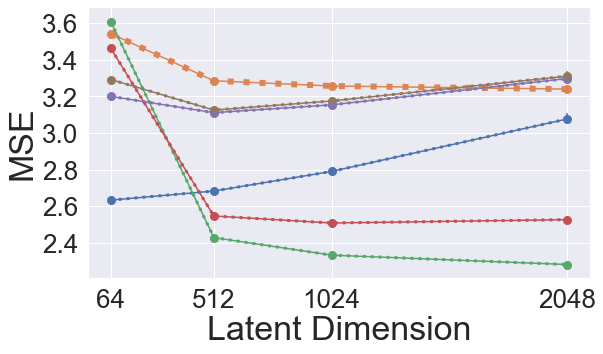

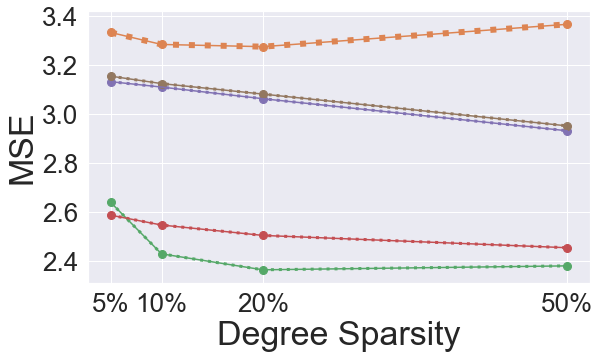

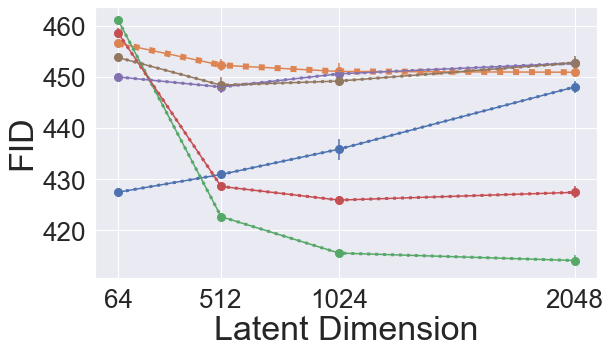

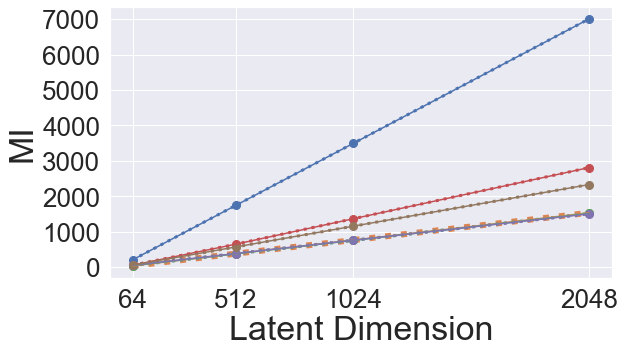

In [11]:
color_list = sns.color_palette()
z_loc_list = np.array([64, 512, 1024, 2048])

"""
plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([iwae_dict[label][str(z)] for z in z_list])
    # Hardcode alpha since the plots slightly overlap
    if idx == 1:
        plt.plot(z_loc_list, val, label=label, lw=6, marker="o", ms=12, linestyle="dotted")
    else:
        plt.plot(z_loc_list, val, label=label, lw=3, marker="o", ms=12, linestyle="dotted")
plt.ylabel("IWAE", fontsize=24)
plt.xlabel("Latent Dimension", fontsize=24)
plt.xticks(z_loc_list, z_list, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=20)
"""

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    mean_val = np.array([np.mean(mse_dict[label][str(z)], axis=0) for z in z_list])
    err_val = np.array([np.std(mse_dict[label][str(z)], axis=0) for z in z_list])
    # Hardcode alpha since the plots slightly overlap
    if idx == 1:
        plt.plot(z_loc_list, mean_val, label=label, lw=6, marker="o", ms=8, linestyle="dotted")
    else:
        plt.plot(z_loc_list, mean_val, label=label, lw=3, marker="o", ms=8, linestyle="dotted")
    plt.errorbar(z_loc_list, mean_val, yerr=err_val, color=color_list[idx])
plt.ylabel("MSE", fontsize=34)
plt.xlabel("Latent Dimension", fontsize=34)
plt.xticks(z_loc_list, z_list, fontsize=26)
plt.yticks(fontsize=26)
#plt.legend(fontsize=16)
#plt.ylim([2.5, 4.0])

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels[1:]):
    print(label)
    val = np.array([np.mean(sparse_mse[label][str(sparsity)], axis=0) for sparsity in sparsity_degree])
    err = np.array([np.std(sparse_mse[label][str(sparsity)], axis=0) for sparsity in sparsity_degree])
    # Hardcode alpha since the plots slightly overlap
    if idx == 0:
        plt.plot(sparsity_degree, val, label=label, lw=6, marker="o", ms=8, linestyle="dotted", color=color_list[idx+1])
    else:
        plt.plot(sparsity_degree, val, label=label, lw=3, marker="o", ms=8, linestyle="dotted", color=color_list[idx+1])
    plt.errorbar(sparsity_degree, val, yerr=err, color=color_list[idx+1])
plt.ylabel("MSE", fontsize=34)
plt.xlabel("Degree Sparsity", fontsize=34)
plt.xticks(np.array(sparsity_degree), [f"{s}%" for s in sparsity_degree], fontsize=26)
plt.yticks(fontsize=26)
#plt.legend(fontsize=16)
#plt.ylim([2.5, 4.0])

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([np.mean(fid[label][str(z)], axis=0) for z in z_list])
    err = np.array([np.std(fid[label][str(z)], axis=0) for z in z_list])

    # Hardcode alpha since the plots slightly overlap
    if idx == 1:
        plt.plot(z_loc_list, val, label=label, lw=6, marker="o", ms=8, linestyle="dotted")
    else:
        plt.plot(z_loc_list, val, label=label, lw=3, marker="o", ms=8, linestyle="dotted")
    plt.errorbar(z_loc_list, val, yerr=err, color=color_list[idx])

plt.ylabel("FID", fontsize=34)
plt.xlabel("Latent Dimension", fontsize=34)
plt.xticks(z_loc_list, z_list, fontsize=26)
plt.yticks(fontsize=26)
#plt.legend(fontsize=18)

plt.figure(figsize=(9,5))
for idx, label in enumerate(file_labels):
    val = np.array([np.mean(multi_info[label][str(z)], axis=0) for z in z_list])
    err = np.array([np.std(multi_info[label][str(z)], axis=0) for z in z_list])

    # Hardcode alpha since the plots slightly overlap
    if idx == 1:
        plt.plot(z_loc_list, val, label=label, lw=6, marker="o", ms=8, linestyle="dotted")
    else:
        plt.plot(z_loc_list, val, label=label, lw=3, marker="o", ms=8, linestyle="dotted")
    plt.errorbar(z_loc_list, val, yerr=err, color=color_list[idx])

plt.ylabel("MI", fontsize=34)
plt.xlabel("Latent Dimension", fontsize=34)
plt.xticks(z_loc_list, z_list, fontsize=26)
plt.yticks(fontsize=26)
#plt.legend(fontsize=16)